#**Principe général d’un GAN**

**Un GAN (Generative Adversarial Network) **est un type de réseau de neurones composé de deux modèles en compétition :

1. Le Générateur (Generator, G) : il prend un vecteur aléatoire (souvent appelé noise vector ou latent vector) et génère une image. Le but est de produire des images réalistes qui trompent le Discriminateur.

2. Le Discriminateur (Discriminator, D) : il reçoit une image et prédit si elle est réelle (provenant du dataset) ou fausse (produite par le générateur).

Le GAN fonctionne comme un jeu à somme nulle :

1. G essaie de tromper D en générant des images réalistes.

2. D essaie de détecter les images fausses.

3. Les deux réseaux s’entraînent simultanément pour s’améliorer mutuellement.

La fonction de perte utilisée est la Binary Cross Entropy (BCE) :

. Pour D : on veut que les vraies images soient classées comme 1 et les fausses comme 0.

. Pour G : on veut que les images générées soient classées comme vraies (1) par D.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bs = 100
z_dim = 100

In [ ]:

# =====================
# MNIST Dataset
# =====================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # 1 canal pour MNIST
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

# =====================
# Generator
# =====================

#Input : un vecteur aléatoire de dimension z_dim (ici 100).

#Hidden layers : 256 → 512 → 1024 neurones avec activation LeakyReLU.

#Output : vecteur de taille 28*28 = 784 pixels avec tanh pour que les valeurs soient entre -1 et 1.

#Rôle : transformer un vecteur aléatoire en image réaliste.

class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super().__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, g_output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        return x

# =====================
# Discriminator
# =====================

#Input : image aplatie (28*28=784).

#Hidden layers : 1024 → 512 → 256 neurones avec LeakyReLU et dropout (empêche le surapprentissage).

#Output : 1 valeur entre 0 et 1 (sigmoid) qui indique la probabilité que l’image soit réelle.

class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

# =====================
# Initialisation
# =====================
mnist_dim = train_dataset.data.shape[1] * train_dataset.data.shape[2]

G = Generator(z_dim, mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

criterion = nn.BCELoss() #BCE : Binary Cross Entropy pour classifier réel/faux.
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

# =====================
# Fonctions d'entraînement
# =====================

#On entraîne D à distinguer le réel du faux.

#x_fake.detach() empêche les gradients de remonter jusqu’au générateur (on ne veut pas entraîner G ici).

#D essaie de maximiser la probabilité de classification correcte.

def D_train(x):
    D.zero_grad()
    batch_size = x.size(0)

    x_real = x.view(batch_size, -1).to(device)
    y_real = torch.ones(batch_size, 1).to(device)

    D_real_loss = criterion(D(x_real), y_real)

    z = torch.randn(batch_size, z_dim).to(device)
    x_fake = G(z)
    y_fake = torch.zeros(batch_size, 1).to(device)

    D_fake_loss = criterion(D(x_fake.detach()), y_fake)

    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return D_loss.item()

#On entraîne G à tromper D.

#On met y=1 car on veut que D pense que les images générées sont réelles.
def G_train(x):
    G.zero_grad()
    batch_size = x.size(0)

    z = torch.randn(batch_size, z_dim).to(device)
    y = torch.ones(batch_size, 1).to(device)

    G_loss = criterion(D(G(z)), y)
    G_loss.backward()
    G_optimizer.step()

    return G_loss.item()


In [ ]:



# =====================
# Boucle d'entraînement
# =====================

#Pour chaque epoch, on entraîne D et G sur chaque batch.

#On calcule la perte moyenne pour suivre la convergence.

#Avec le temps :

#D devient meilleur pour détecter le faux

#G devient meilleur pour générer du réaliste.


n_epoch = 50
for epoch in range(1, n_epoch+1):
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print(f"[{epoch}/{n_epoch}] loss_d: {sum(D_losses)/len(D_losses):.3f}, loss_g: {sum(G_losses)/len(G_losses):.3f}")


[1/50] loss_d: 0.839, loss_g: 2.982
[2/50] loss_d: 1.012, loss_g: 2.252
[3/50] loss_d: 0.995, loss_g: 1.779
[4/50] loss_d: 0.874, loss_g: 2.016
[5/50] loss_d: 0.710, loss_g: 2.047
[6/50] loss_d: 0.537, loss_g: 2.721
[7/50] loss_d: 0.568, loss_g: 2.593
[8/50] loss_d: 0.618, loss_g: 2.231
[9/50] loss_d: 0.590, loss_g: 2.455
[10/50] loss_d: 0.647, loss_g: 2.336
[11/50] loss_d: 0.687, loss_g: 2.199
[12/50] loss_d: 0.716, loss_g: 2.092
[13/50] loss_d: 0.701, loss_g: 2.250
[14/50] loss_d: 0.702, loss_g: 2.138
[15/50] loss_d: 0.714, loss_g: 2.077
[16/50] loss_d: 0.816, loss_g: 1.833
[17/50] loss_d: 0.859, loss_g: 1.752
[18/50] loss_d: 0.865, loss_g: 1.726
[19/50] loss_d: 0.846, loss_g: 1.787
[20/50] loss_d: 0.802, loss_g: 1.863
[21/50] loss_d: 0.817, loss_g: 1.834
[22/50] loss_d: 0.872, loss_g: 1.737
[23/50] loss_d: 0.921, loss_g: 1.553
[24/50] loss_d: 0.936, loss_g: 1.556
[25/50] loss_d: 0.926, loss_g: 1.557
[26/50] loss_d: 0.950, loss_g: 1.505
[27/50] loss_d: 0.964, loss_g: 1.496
[28/50] lo

In [ ]:
import os
from torchvision.utils import save_image

# Créer le dossier samples s'il n'existe pas
os.makedirs('./samples', exist_ok=True)

# Nombre d'images à générer
num_samples = bs  # ou un autre nombre si tu veux

with torch.no_grad():
    # Générer des vecteurs aléatoires
    test_z = torch.randn(num_samples, z_dim).to(device)

    # Générer les images
    generated = G(test_z)

    # Reshape et sauvegarde
    save_image(
        generated.view(generated.size(0), 1, 28, 28),  # 1 canal, 28x28
        './samples/sample.png',                        # nom du fichier
        nrow=10,                                       # 10 images par ligne
        normalize=True                                 # normalise entre 0 et 1
    )

print("Images générées sauvegardées dans ./samples/sample.png")


Images générées sauvegardées dans ./samples/sample.png


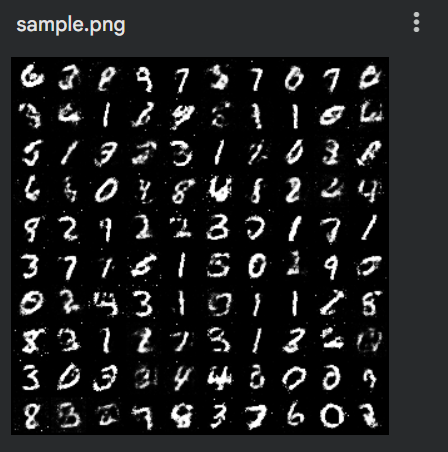

In [ ]:
import torch
import matplotlib.pyplot as plt

G.eval()

with torch.no_grad():
    z = torch.randn(1000, z_dim).to(device)   # 1000 images
    fake_images = G(z)


In [ ]:
real_images = train_dataset.data[:1000].float().to(device)

# Normalisation identique au GAN ([-1,1])
real_images = (real_images / 255.0 - 0.5) / 0.5


In [ ]:
real_pixels = real_images.view(-1).cpu().numpy()
fake_pixels = fake_images.view(-1).cpu().numpy()


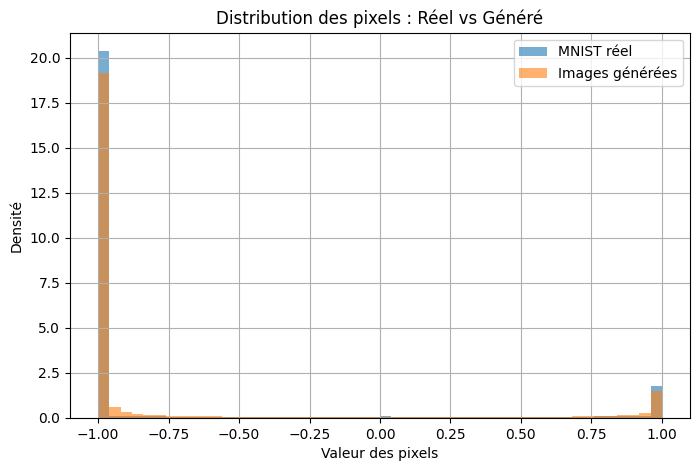

In [ ]:
plt.figure(figsize=(8,5))

plt.hist(real_pixels, bins=50, alpha=0.6, label="MNIST réel", density=True)
plt.hist(fake_pixels, bins=50, alpha=0.6, label="Images générées", density=True)

plt.xlabel("Valeur des pixels")
plt.ylabel("Densité")
plt.title("Distribution des pixels : Réel vs Généré")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("MNIST réel :")
print("Moyenne =", real_pixels.mean())
print("Variance =", real_pixels.var())

print("\nImages générées :")
print("Moyenne =", fake_pixels.mean())
print("Variance =", fake_pixels.var())


MNIST réel :
Moyenne = -0.74352217
Variance = 0.3724388

Images générées :
Moyenne = -0.73369795
Variance = 0.37305763


GAN apprend bien le contraste du MNIST (beaucoup de pixels noirs).

GAN reproduit la diversité des niveaux de gris des images réelles.